In [791]:
# All Imports

# data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge 
from sklearn.model_selection import train_test_split
from sklearn import metrics as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import xgboost as xgb 
import tensorflow as tf 

In [767]:
# create bigquery client
from google.cloud import bigquery
client = bigquery.Client()

In [437]:
# # scrap testing for NAs (comment out when done)
# df_na_test = client.query('select * from `cbbanalytics.models.gs__betting_training_data`').to_dataframe()
# df_na_test.isna().sum()

In [768]:
# grab "gs__betting_training_data" with betting odds CSV joined
sql = 'SELECT * FROM `cbbanalytics.dev_ex.training_data_with_odds`'
raw_df = client.query(sql).to_dataframe()

In [853]:
# rerun from here
games_df = raw_df

In [854]:
# keep games in December - April only
games_df['gameDate'] = pd.to_datetime(games_df['gameDate'])
games_df['month'] = games_df['gameDate'].dt.month
games_df = games_df[games_df['month'].isin([12, 1, 2, 3, 4])]

In [855]:
# import elo data
elo_df = pd.read_csv('eric_xia/elo_per_game.csv') 
elo_df = elo_df[['gameId', 'homeEloPrev', 'awayEloPrev']] 

In [856]:
games_df = pd.merge(games_df, elo_df, on='gameId', how='left')

In [857]:
# Filter for scores existing
games_df = games_df[games_df['homeScore'].notna()]
games_df = games_df[games_df['awayScore'].notna()]
games_df = games_df[games_df['homeFinal'].notna()]
games_df = games_df[games_df['awayFinal'].notna()]

In [858]:
# Set homeScore, awayScore, homeFinal, awayFinal to "int" type
integer_cols = ['homeScore', 'awayScore', 'homeFinal', 'awayFinal']
games_df[integer_cols] = games_df[integer_cols].astype(int)

In [859]:
# find columns where home,away score need switching
switch_filter = (games_df.homeScore == games_df.awayFinal) & (games_df.awayScore == games_df.homeFinal)

# switch the columns  
temp_col = games_df['awayFinal'].copy()
games_df.loc[switch_filter, 'awayFinal'] = df['homeFinal'] 
games_df.loc[switch_filter, 'homeFinal'] = temp_col 

In [860]:
# check for other problematic scores 
filter_prob = (games_df.homeScore != games_df.homeFinal) | (games_df.awayScore != games_df.awayFinal)

# number of problematic columns 
problem_games = games_df[filter_prob][integer_cols]
print(problem_games.shape[0])

149


In [861]:
# keep games that are corrected matched
games_df = games_df[(games_df['homeScore'] == games_df['homeFinal']) & (games_df['awayScore'] == games_df['awayFinal']) ] 
games_df[['homeScore', 'homeFinal', 'awayScore', 'awayFinal']].head(3)

,homeScore,homeFinal,awayScore,awayFinal
0,55,55,51,51.0
2,81,81,60,60.0
3,48,48,57,57.0


In [863]:
# add target variables (first time running won't result in warning)
games_df['result'] = games_df['didHomeWin'].astype(int)
games_df['bookPred'] = (games_df['diffClose'] > 0).astype(int)
games_df['pointsDiff'] = games_df['homeScore'] - games_df['awayScore'] 
games_df['pointsTotal'] = games_df['homeScore'] + games_df['awayScore'] 
games_df['overDiff'] = (games_df['pointsDiff'] > games_df['diffClose']).astype(int)
games_df['overTotal'] = (games_df['pointsTotal'] > games_df['totalClose']).astype(int)
games_df.head(2)

,gameId,gameDate,homePriorGameDate,awayPriorGameDate,competitionId,isNeutral,homeId,awayId,homeDivisionId,awayDivisionId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,daysOffHome,daysOffAway,daysOffDiff,gpHomeSeason,netRtgHomeSeason,ortgHomeSeason,drtgHomeSeason,paceHomeSeason,efgPctHomeSeason,orbPctHomeSeason,tovPctHomeSeason,ftaRateHomeSeason,fgPctHomeSeason,fg2PctHomeSeason,fg3PctHomeSeason,fga3RateHomeSeason,ftPctHomeSeason,tsPctHomeSeason,astPctHomeSeason,astRatioHomeSeason,blkPctHomeSeason,stlPctHomeSeason,drbPctHomeSeason,pfEffHomeSeason,stlPerPfHomeSeason,blkPerPfHomeSeason,fgaHomeSeason,fga2HomeSeason,fga3HomeSeason,ptsScoredP100HomeSeason,fgaP100HomeSeason,fga2P100HomeSeason,fga3P100HomeSeason,ftaP100HomeSeason,astP100HomeSeason,orbP100HomeSeason,drbP100HomeSeason,rebP100HomeSeason,stlP100HomeSeason,blkP100HomeSeason,pfdP100HomeSeason,gpAwaySeason,netRtgAwaySeason,ortgAwaySeason,drtgAwaySeason,paceAwaySeason,efgPctAwaySeason,orbPctAwaySeason,tovPctAwaySeason,ftaRateAwaySeason,fgPctAwaySeason,fg2PctAwaySeason,fg3PctAwaySeason,fga3RateAwaySeason,ftPctAwaySeason,tsPctAwaySeason,astPctAwaySeason,astRatioAwaySeason,blkPctAwaySeason,stlPctAwaySeason,drbPctAwaySeason,pfEffAwaySeason,stlPerPfAwaySeason,blkPerPfAwaySeason,fgaAwaySeason,fga2AwaySeason,fga3AwaySeason,ptsScoredP100AwaySeason,fgaP100AwaySeason,fga2P100AwaySeason,fga3P100AwaySeason,ftaP100AwaySeason,astP100AwaySeason,orbP100AwaySeason,drbP100AwaySeason,rebP100AwaySeason,stlP100AwaySeason,blkP100AwaySeason,pfdP100AwaySeason,gpHomeL5g,netRtgHomeL5g,ortgHomeL5g,drtgHomeL5g,paceHomeL5g,efgPctHomeL5g,orbPctHomeL5g,tovPctHomeL5g,ftaRateHomeL5g,fgPctHomeL5g,fg2PctHomeL5g,fg3PctHomeL5g,fga3RateHomeL5g,ftPctHomeL5g,tsPctHomeL5g,astPctHomeL5g,astRatioHomeL5g,blkPctHomeL5g,stlPctHomeL5g,drbPctHomeL5g,pfEffHomeL5g,stlPerPfHomeL5g,blkPerPfHomeL5g,fgaHomeL5g,fga2HomeL5g,fga3HomeL5g,ptsScoredP100HomeL5g,fgaP100HomeL5g,fga2P100HomeL5g,fga3P100HomeL5g,ftaP100HomeL5g,astP100HomeL5g,orbP100HomeL5g,drbP100HomeL5g,rebP100HomeL5g,stlP100HomeL5g,blkP100HomeL5g,pfdP100HomeL5g,gpAwayL5g,netRtgAwayL5g,ortgAwayL5g,drtgAwayL5g,paceAwayL5g,efgPctAwayL5g,orbPctAwayL5g,tovPctAwayL5g,ftaRateAwayL5g,fgPctAwayL5g,fg2PctAwayL5g,fg3PctAwayL5g,fga3RateAwayL5g,ftPctAwayL5g,tsPctAwayL5g,astPctAwayL5g,astRatioAwayL5g,blkPctAwayL5g,stlPctAwayL5g,drbPctAwayL5g,pfEffAwayL5g,stlPerPfAwayL5g,blkPerPfAwayL5g,fgaAwayL5g,fga2AwayL5g,fga3AwayL5g,ptsScoredP100AwayL5g,fgaP100AwayL5g,fga2P100AwayL5g,fga3P100AwayL5g,ftaP100AwayL5g,astP100AwayL5g,orbP100AwayL5g,drbP100AwayL5g,rebP100AwayL5g,stlP100AwayL5g,blkP100AwayL5g,pfdP100AwayL5g,gpDiffSeason,gpDiffL5g,netRtgDiffSeason,netRtgDiffL5g,ortgDiffSeason,ortgDiffL5g,drtgDiffSeason,drtgDiffL5g,paceDiffSeason,paceDiffL5g,efgPctDiffSeason,efgPctDiffL5g,orbPctDiffSeason,orbPctDiffL5g,tovPctDiffSeason,tovPctDiffL5g,ftaRateDiffSeason,ftaRateDiffL5g,fgPctDiffSeason,fgPctDiffL5g,fg2PctDiffSeason,fg2PctDiffL5g,fg3PctDiffSeason,fg3PctDiffL5g,fga3RateDiffSeason,fga3RateDiffL5g,ftPctDiffSeason,ftPctDiffL5g,tsPctDiffSeason,tsPctDiffL5g,astPctDiffSeason,astPctDiffL5g,astRatioDiffSeason,astRatioDiffL5g,blkPctDiffSeason,blkPctDiffL5g,stlPctDiffSeason,stlPctDiffL5g,drbPctDiffSeason,drbPctDiffL5g,pfEffDiffSeason,pfEffDiffL5g,stlPerPfDiffSeason,stlPerPfDiffL5g,blkPerPfDiffSeason,blkPerPfDiffL5g,fgaDiffSeason,fgaDiffL5g,fga2DiffSeason,fga2DiffL5g,fga3DiffSeason,fga3DiffL5g,ptsScoredP100DiffSeason,ptsScoredP100DiffL5g,fgaP100DiffSeason,fgaP100DiffL5g,fga2P100DiffSeason,fga2P100DiffL5g,fga3P100DiffSeason,fga3P100DiffL5g,ftaP100DiffSeason,ftaP100DiffL5g,astP100DiffSeason,astP100DiffL5g,orbP100DiffSeason,orbP100DiffL5g,drbP100DiffSeason,drbP100DiffL5g,rebP100DiffSeason,rebP100DiffL5g,stlP100DiffSeason,stlP100DiffL5g,blkP100DiffSeason,blkP100DiffL5g,pfdP100DiffSeason,pfdP100DiffL5g,homeFinal,awayFinal,diffClose,totalClose,homeMoneyLine,awayMoneyLine,month,homeEloPrev,awayEloPrev,result,bookPred,pointsDiff,pointsTotal,overDiff,overTotal
0,1039029,2019-01-24,2019-01-21,2019-01-16,22850,Fa

In [864]:
# add column diffBet; set a prediction threshold of 15 points or more
def diff_target(diffClose, pointsDiff): 
    pred_diff = pointsDiff - diffClose 
    if abs(pred_diff) >= 15: 
        return 1 
    else: 
        return 0

games_df['diffBet'] = games_df.apply(lambda x: diff_target(x.diffClose, x.pointsDiff), axis=1)

# 1-liner for this whole logic 
# games_df['diffBet'] = games_df.apply(lambda x: return 1 if abs(x.pointsDiff - x.diffClose) < 15 else 0), axis=1）

In [865]:
# check diffClose is correct
games_df[games_df['diffClose'] > games_df['totalClose']]

,gameId,gameDate,homePriorGameDate,awayPriorGameDate,competitionId,isNeutral,homeId,awayId,homeDivisionId,awayDivisionId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,daysOffHome,daysOffAway,daysOffDiff,gpHomeSeason,netRtgHomeSeason,ortgHomeSeason,drtgHomeSeason,paceHomeSeason,efgPctHomeSeason,orbPctHomeSeason,tovPctHomeSeason,ftaRateHomeSeason,fgPctHomeSeason,fg2PctHomeSeason,fg3PctHomeSeason,fga3RateHomeSeason,ftPctHomeSeason,tsPctHomeSeason,astPctHomeSeason,astRatioHomeSeason,blkPctHomeSeason,stlPctHomeSeason,drbPctHomeSeason,pfEffHomeSeason,stlPerPfHomeSeason,blkPerPfHomeSeason,fgaHomeSeason,fga2HomeSeason,fga3HomeSeason,ptsScoredP100HomeSeason,fgaP100HomeSeason,fga2P100HomeSeason,fga3P100HomeSeason,ftaP100HomeSeason,astP100HomeSeason,orbP100HomeSeason,drbP100HomeSeason,rebP100HomeSeason,stlP100HomeSeason,blkP100HomeSeason,pfdP100HomeSeason,gpAwaySeason,netRtgAwaySeason,ortgAwaySeason,drtgAwaySeason,paceAwaySeason,efgPctAwaySeason,orbPctAwaySeason,tovPctAwaySeason,ftaRateAwaySeason,fgPctAwaySeason,fg2PctAwaySeason,fg3PctAwaySeason,fga3RateAwaySeason,ftPctAwaySeason,tsPctAwaySeason,astPctAwaySeason,astRatioAwaySeason,blkPctAwaySeason,stlPctAwaySeason,drbPctAwaySeason,pfEffAwaySeason,stlPerPfAwaySeason,blkPerPfAwaySeason,fgaAwaySeason,fga2AwaySeason,fga3AwaySeason,ptsScoredP100AwaySeason,fgaP100AwaySeason,fga2P100AwaySeason,fga3P100AwaySeason,ftaP100AwaySeason,astP100AwaySeason,orbP100AwaySeason,drbP100AwaySeason,rebP100AwaySeason,stlP100AwaySeason,blkP100AwaySeason,pfdP100AwaySeason,gpHomeL5g,netRtgHomeL5g,ortgHomeL5g,drtgHomeL5g,paceHomeL5g,efgPctHomeL5g,orbPctHomeL5g,tovPctHomeL5g,ftaRateHomeL5g,fgPctHomeL5g,fg2PctHomeL5g,fg3PctHomeL5g,fga3RateHomeL5g,ftPctHomeL5g,tsPctHomeL5g,astPctHomeL5g,astRatioHomeL5g,blkPctHomeL5g,stlPctHomeL5g,drbPctHomeL5g,pfEffHomeL5g,stlPerPfHomeL5g,blkPerPfHomeL5g,fgaHomeL5g,fga2HomeL5g,fga3HomeL5g,ptsScoredP100HomeL5g,fgaP100HomeL5g,fga2P100HomeL5g,fga3P100HomeL5g,ftaP100HomeL5g,astP100HomeL5g,orbP100HomeL5g,drbP100HomeL5g,rebP100HomeL5g,stlP100HomeL5g,blkP100HomeL5g,pfdP100HomeL5g,gpAwayL5g,netRtgAwayL5g,ortgAwayL5g,drtgAwayL5g,paceAwayL5g,efgPctAwayL5g,orbPctAwayL5g,tovPctAwayL5g,ftaRateAwayL5g,fgPctAwayL5g,fg2PctAwayL5g,fg3PctAwayL5g,fga3RateAwayL5g,ftPctAwayL5g,tsPctAwayL5g,astPctAwayL5g,astRatioAwayL5g,blkPctAwayL5g,stlPctAwayL5g,drbPctAwayL5g,pfEffAwayL5g,stlPerPfAwayL5g,blkPerPfAwayL5g,fgaAwayL5g,fga2AwayL5g,fga3AwayL5g,ptsScoredP100AwayL5g,fgaP100AwayL5g,fga2P100AwayL5g,fga3P100AwayL5g,ftaP100AwayL5g,astP100AwayL5g,orbP100AwayL5g,drbP100AwayL5g,rebP100AwayL5g,stlP100AwayL5g,blkP100AwayL5g,pfdP100AwayL5g,gpDiffSeason,gpDiffL5g,netRtgDiffSeason,netRtgDiffL5g,ortgDiffSeason,ortgDiffL5g,drtgDiffSeason,drtgDiffL5g,paceDiffSeason,paceDiffL5g,efgPctDiffSeason,efgPctDiffL5g,orbPctDiffSeason,orbPctDiffL5g,tovPctDiffSeason,tovPctDiffL5g,ftaRateDiffSeason,ftaRateDiffL5g,fgPctDiffSeason,fgPctDiffL5g,fg2PctDiffSeason,fg2PctDiffL5g,fg3PctDiffSeason,fg3PctDiffL5g,fga3RateDiffSeason,fga3RateDiffL5g,ftPctDiffSeason,ftPctDiffL5g,tsPctDiffSeason,tsPctDiffL5g,astPctDiffSeason,astPctDiffL5g,astRatioDiffSeason,astRatioDiffL5g,blkPctDiffSeason,blkPctDiffL5g,stlPctDiffSeason,stlPctDiffL5g,drbPctDiffSeason,drbPctDiffL5g,pfEffDiffSeason,pfEffDiffL5g,stlPerPfDiffSeason,stlPerPfDiffL5g,blkPerPfDiffSeason,blkPerPfDiffL5g,fgaDiffSeason,fgaDiffL5g,fga2DiffSeason,fga2DiffL5g,fga3DiffSeason,fga3DiffL5g,ptsScoredP100DiffSeason,ptsScoredP100DiffL5g,fgaP100DiffSeason,fgaP100DiffL5g,fga2P100DiffSeason,fga2P100DiffL5g,fga3P100DiffSeason,fga3P100DiffL5g,ftaP100DiffSeason,ftaP100DiffL5g,astP100DiffSeason,astP100DiffL5g,orbP100DiffSeason,orbP100DiffL5g,drbP100DiffSeason,drbP100DiffL5g,rebP100DiffSeason,rebP100DiffL5g,stlP100DiffSeason,stlP100DiffL5g,blkP100DiffSeason,blkP100DiffL5g,pfdP100DiffSeason,pfdP100DiffL5g,homeFinal,awayFinal,diffClose,totalClose,homeMoneyLine,awayMoneyLine,month,homeEloPrev,awayEloPrev,result,bookPred,pointsDiff,pointsTotal,overDiff,overTotal,diffBet


## Baseline

In [866]:
# Accuracy according to sportsbook
book_acc = len(games_df[games_df['bookPred']  == games_df['result']]) / len(games_df)
print('Sportsbook accuracy: ', book_acc)

Sportsbook accuracy:  0.7146984470928133


In [867]:
# Accuracy by predicting home team to win
homewin_pct = games_df[games_df['result'] == 1]['result'].count() / games_df['result'].count()
print('Home win percentage: ', homewin_pct)

Home win percentage:  0.622174070061394


In [868]:
# define plot function 
def plot_predictions(y_test, pred): 
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, pred)
    plt.xlabel('True Score')
    plt.ylabel('Predictions')
    lims = [y_test.min(), y_test.max()]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

Points diff r2:  0.32278034884095774


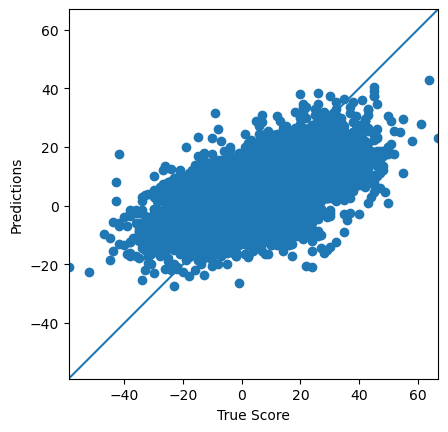

In [869]:
# r^2 of book's prediction of points differential 
print('Points diff r2: ', sm.r2_score(games_df['pointsDiff'], games_df['diffClose']))
plot_predictions(games_df['pointsDiff'], games_df['diffClose'])

Total points r2:  0.22078422096828831


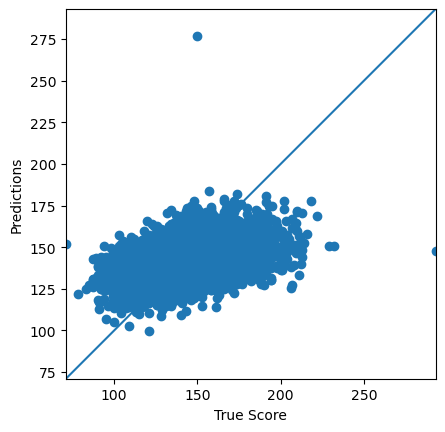

In [870]:
# r^2 of book's prediction of total points 
print('Total points r2: ', sm.r2_score(games_df['pointsTotal'], games_df['totalClose'])) 
plot_predictions(games_df['pointsTotal'], games_df['totalClose'])

### PCA 

In [874]:
# features used in model fitting  
features = ['netRtgDiffSeason', 'netRtgDiffL5g', 'ortgDiffSeason', 
'ortgDiffL5g', 'drtgDiffSeason', 'drtgDiffL5g', 'paceDiffSeason', 
'paceDiffL5g', 'efgPctDiffSeason', 'efgPctDiffL5g', 'orbPctDiffSeason', 
'orbPctDiffL5g', 'tovPctDiffSeason', 'tovPctDiffL5g', 'ftaRateDiffSeason', 'ftaRateDiffL5g', 
'fgPctDiffSeason', 'fgPctDiffL5g', 'fg2PctDiffSeason', 'fg2PctDiffL5g', 
'fg3PctDiffSeason', 'fg3PctDiffL5g', 'fga3RateDiffSeason', 'fga3RateDiffL5g', 
'ftPctDiffSeason', 'ftPctDiffL5g', 'tsPctDiffSeason', 'tsPctDiffL5g', 
'astPctDiffSeason', 'astPctDiffL5g', 'astRatioDiffSeason', 'astRatioDiffL5g', 
'blkPctDiffSeason', 'blkPctDiffL5g', 'stlPctDiffSeason', 'stlPctDiffL5g', 
'drbPctDiffSeason', 'drbPctDiffL5g', 'pfEffDiffSeason', 'pfEffDiffL5g', 
'stlPerPfDiffSeason', 'stlPerPfDiffL5g', 'blkPerPfDiffSeason', 'blkPerPfDiffL5g', 
'fgaDiffSeason', 'fgaDiffL5g', 'fga2DiffSeason', 'fga2DiffL5g', 
'fga3DiffSeason', 'fga3DiffL5g', 'ptsScoredP100DiffSeason', 'ptsScoredP100DiffL5g', 
'fgaP100DiffSeason', 'fgaP100DiffL5g','fga2P100DiffSeason','fga2P100DiffL5g',
'fga3P100DiffSeason','fga3P100DiffL5g','ftaP100DiffSeason','ftaP100DiffL5g',
'astP100DiffSeason','astP100DiffL5g','orbP100DiffSeason','orbP100DiffL5g',
'drbP100DiffSeason','drbP100DiffL5g','rebP100DiffSeason','rebP100DiffL5g',
'stlP100DiffSeason','stlP100DiffL5g','blkP100DiffSeason','blkP100DiffL5g',
'pfdP100DiffSeason','pfdP100DiffL5g', 'homeEloPrev', 'awayEloPrev']


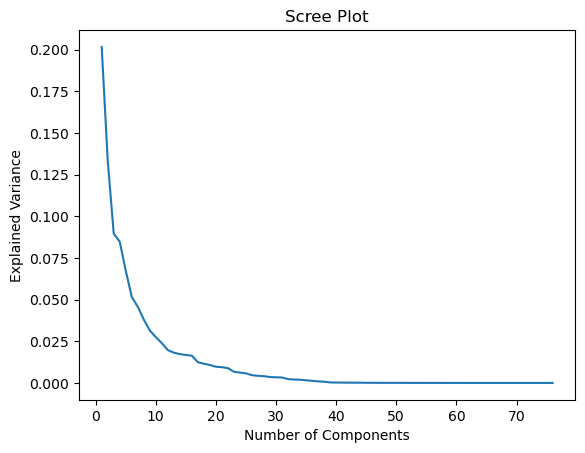

In [875]:
X = games_df[features].values 
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform PCA on the data
pca = PCA()
pca.fit(X)

# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance by each component
plt.plot(np.arange(len(explained_variance))+1, explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("Scree Plot")
plt.show()

## fit_model() function 

In [978]:
# confusion matrix 
def plot_cmatrix(model, y_pred, y_test): 
    color = 'black'
    Labels = ['0', '1']
    cm = sm.confusion_matrix(y_test, y_pred, labels=model[1].classes_)
    disp = sm.ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model[1].classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# prediction vs. true value plot 
def plot_predictions(y_test, pred, target): 
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, pred)
    plt.xlabel('True Score ')
    plt.ylabel('Predictions')
    lims = [y_test.min(), y_test.max()]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title(target)
    _ = plt.plot(lims, lims)
    
# fits specified models on data, returns relevant results as a dictionary 
def fit_model(training_df, features, label, model_type, pred_type='c', cross_val=False):
    # training_df: dataframe containing training dataset
    # features: features used to train the model
    # label: target variable to be predicted 
    # model_type: model used to make the prediction (c, log_r, dt, rf, nb, svc, lin_r, svr, ridge)
    # pred_type: prediction type (c or r) 
    # cross_val: cross validate during training
    # pred_target: a string that describes the prediction target
    
    # define the X and Y variabes
    X = training_df[features].values 
    y= training_df[label].values 
    
    # split variables into training and testing set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)
    
    pred_target = label + "Pred"
    # create specified classification model
    if pred_type == 'c': 
        if model_type == 'log_r': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), LogisticRegression(solver='lbfgs', max_iter=3000))
        elif model_type== 'dt': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), DecisionTreeClassifier()) 
        elif model_type == 'rf': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), RandomForestClassifier())
        elif model_type == 'nb': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), GaussianNB())
        elif model_type == 'svc': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), SVC())

        # fit model on training data 
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        # save metrics in a dictionary to be returned
        accuracy = sm.accuracy_score(y_test, y_pred) 
        class_report = classification_report(y_test, y_pred) 
        result = {'model': model, 'y_pred': y_pred, 'y_test': y_test, 'accuracy': accuracy, 'class_report': class_report, 'target': pred_target}
        if cross_val: 
            result['cross_val'] = cross_val_score(model, X, y, cv=10)
    
    # create specified regression model 
    elif pred_type == 'r': 
        if model_type == 'lin_r': 
            model = make_pipeline(StandardScaler(), LinearRegression())
        elif model_type == 'svr': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), SVR())
        elif model_type == 'ridge': 
            model = make_pipeline(StandardScaler(), PCA(n_components=0.92), Ridge())
        
        # fit model on training data 
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        
        # save metrics in a dictionary to be returned
        r_squared = sm.r2_score(y_test, y_pred)
        RMSE = sm.mean_squared_error(y_test, y_pred, squared=False)
        result = {'model': model, 'y_pred': y_pred, 'y_test': y_test, 'r_squared': r_squared, 'RMSE': RMSE,  'target': pred_target} 
        
    
    return result 

### Fit models 

In [979]:
# predicting win/loss with logistic regression 
game_pred = fit_model(games_df,  features, 'result', 'log_r', cross_val=True)
print(game_pred['cross_val'])
print("mean: ", game_pred['cross_val'].mean())
print("standard deviation: ", game_pred['cross_val'].std())

[0.6866426  0.67725632 0.69386282 0.70180505 0.71768953 0.70303468
 0.68208092 0.66907514 0.70736994 0.67702312]
mean:  0.6915840132718432
standard deviation:  0.014866579611798925


In [980]:
# predicting point spread with linear regression 
diff_pred = fit_model(games_df,  features, 'pointsDiff', 'lin_r', 'r')
print(diff_pred['r_squared'])

0.26806932133511685


In [981]:
# predicting betting over or under the point spread with random forest
over_diff_pred_rf = fit_model(games_df,  features, 'overDiff', 'rf')
print(over_diff_pred_rf['accuracy'])

0.5091478093403948


In [982]:
# predicting betting over or under points spread with decision tree
over_diff_pred_dt = fit_model(games_df,  features, 'overDiff', 'dt')
print(over_diff_pred_dt['accuracy'])

0.5105922002888782


In [983]:
over_diff_pred_lr = fit_model(games_df, features, 'overDiff', 'log_r', cross_val=True)
print(over_diff_pred_lr['cross_val'])
print("mean: ", over_diff_pred_lr['cross_val'].mean())
print("standard deviation: ", over_diff_pred_lr['cross_val'].std())

[0.52563177 0.51841155 0.49819495 0.5234657  0.52418773 0.50361272
 0.52095376 0.53757225 0.51878613 0.51589595]
mean:  0.5186712505999458
standard deviation:  0.010574243634030185


In [984]:
# predicting betting over or under points total with logistic regression
over_total_pred_lr = fit_model(games_df,  features, 'overTotal', 'log_r', cross_val=True)
print(over_total_pred['cross_val'])
print("mean: ", over_total_pred_lr['cross_val'].mean())
print("standard deviation: ", over_total_pred_lr['cross_val'].std())

[0.52274368 0.51046931 0.52129964 0.50685921 0.49891697 0.50216763
 0.50433526 0.48482659 0.48843931 0.50144509]
mean:  0.504150268149663
standard deviation:  0.0116016983507716


## Visualize predictions

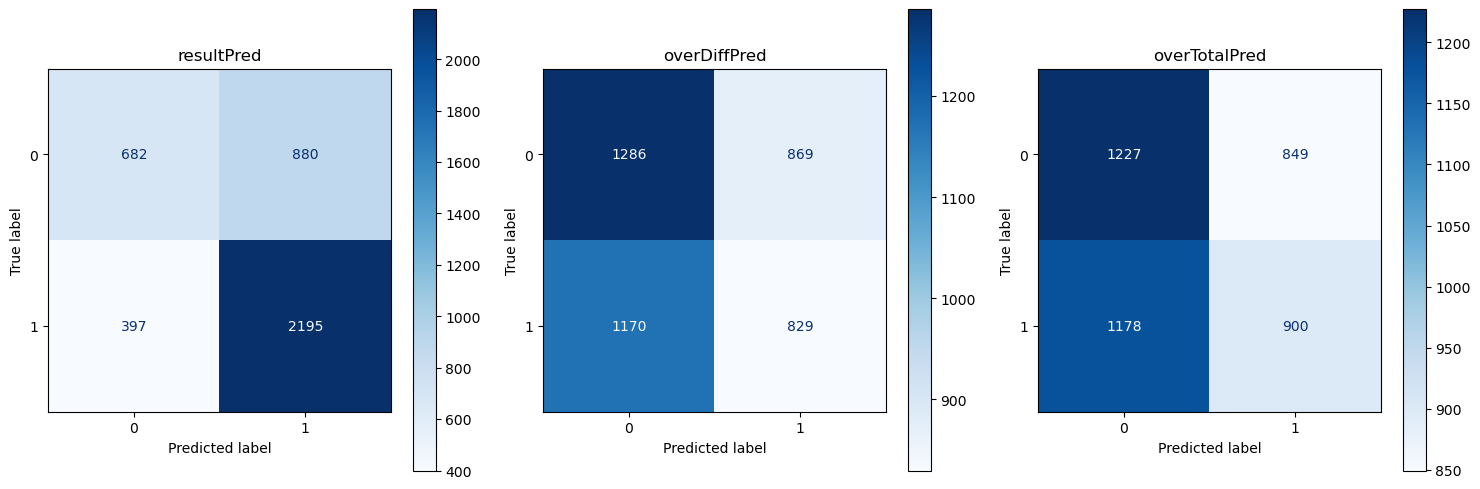

In [986]:
# plot three confusion matrices for classification models
model1 = game_pred 
model2 = over_diff_pred_rf 
model3 = over_total_pred
color = 'black'
Labels = ['0', '1']

# create subplots of confusion matrices 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

cm1 = sm.confusion_matrix(model1['y_test'], model1['y_pred'], labels=model1['model'][2].classes_)
disp1 = sm.ConfusionMatrixDisplay(confusion_matrix=cm1,
                         display_labels=model1['model'][2].classes_)
disp1.plot(ax=ax1, cmap=plt.cm.Blues)
ax1.set_title(model1['target'])

cm2 = sm.confusion_matrix(model2['y_test'], model2['y_pred'], labels=model2['model'][2].classes_)
disp2 = sm.ConfusionMatrixDisplay(confusion_matrix=cm2,
                         display_labels=model2['model'][2].classes_)
disp2.plot(ax=ax2, cmap=plt.cm.Blues)
ax2.set_title(model2['target'])

cm3 = sm.confusion_matrix(model3['y_test'], model3['y_pred'], labels=model3['model'][2].classes_)
disp3 = sm.ConfusionMatrixDisplay(confusion_matrix=cm3,
                         display_labels=model3['model'][2].classes_)
disp3.plot(ax=ax3, cmap=plt.cm.Blues)
ax3.set_title(model3['target'])

plt.tight_layout()
plt.show()


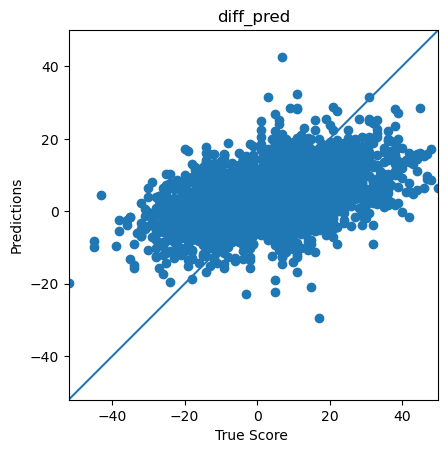

In [754]:
# plot scatterplot for point differential prediction 
plot_predictions(diff_pred['y_test'], diff_pred['y_pred'], diff_pred['target'])

## predict todays games

In [907]:
# returns a new dataframe containing gameDate, teamMarkets, and prediction target variables
def predict_todays_games(games_today, features, models_list): 
    # games_today: a dataframe containing games to be predicted 
    # features: features used to make predictions 
    # models_list: a list of trained models used to make predictions
    
    # convert features to a numpy array 
    X = games_today[features].values
    # basic columns for the resulting dataframe (can change) 
    col_list = ['gameDate', 'homeMarket', 'awayMarket']
    pred_df = games_today[col_list].copy()
    # each model in models_list returns a prediction to be added to the final dataframe
    for i in range(len(models_list)):
        model = models_list[i]['model'] 
        pred = model.predict(X)
        pred_target = models_list[i]['target'] 
        pred_df[pred_target] = pred 
    return pred_df

In [959]:
# get unplayed games 
games_today = raw_df[raw_df['homeScore'].isna() & raw_df['awayScore'].isna()]

In [960]:
# get most recent team elos 
most_recent_elo = pd.read_csv('eric_xia/most_recent_elo.csv')
elo_dict = {}
for i in range(most_recent_elo.shape[0]):
    elo_dict[most_recent_elo.iloc[i]['teamId']] = most_recent_elo.iloc[i]['elo']

In [961]:
# add elos to games_today df 
# no need to add elo if trained without elo (currently missing teams)
games_today['homeEloPrev'] = games_today['homeId'].apply(lambda x: elo_dict[x] if x in elo_dict else 1500)
games_today['awayEloPrev'] = games_today['awayId'].apply(lambda x: elo_dict[x] if x in elo_dict else 1500)
games_today.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,gameId,gameDate,homePriorGameDate,awayPriorGameDate,competitionId,isNeutral,homeId,awayId,homeDivisionId,awayDivisionId,homeMarket,awayMarket,homeScore,awayScore,didHomeWin,daysOffHome,daysOffAway,daysOffDiff,gpHomeSeason,netRtgHomeSeason,ortgHomeSeason,drtgHomeSeason,paceHomeSeason,efgPctHomeSeason,orbPctHomeSeason,tovPctHomeSeason,ftaRateHomeSeason,fgPctHomeSeason,fg2PctHomeSeason,fg3PctHomeSeason,fga3RateHomeSeason,ftPctHomeSeason,tsPctHomeSeason,astPctHomeSeason,astRatioHomeSeason,blkPctHomeSeason,stlPctHomeSeason,drbPctHomeSeason,pfEffHomeSeason,stlPerPfHomeSeason,blkPerPfHomeSeason,fgaHomeSeason,fga2HomeSeason,fga3HomeSeason,ptsScoredP100HomeSeason,fgaP100HomeSeason,fga2P100HomeSeason,fga3P100HomeSeason,ftaP100HomeSeason,astP100HomeSeason,orbP100HomeSeason,drbP100HomeSeason,rebP100HomeSeason,stlP100HomeSeason,blkP100HomeSeason,pfdP100HomeSeason,gpAwaySeason,netRtgAwaySeason,ortgAwaySeason,drtgAwaySeason,paceAwaySeason,efgPctAwaySeason,orbPctAwaySeason,tovPctAwaySeason,ftaRateAwaySeason,fgPctAwaySeason,fg2PctAwaySeason,fg3PctAwaySeason,fga3RateAwaySeason,ftPctAwaySeason,tsPctAwaySeason,astPctAwaySeason,astRatioAwaySeason,blkPctAwaySeason,stlPctAwaySeason,drbPctAwaySeason,pfEffAwaySeason,stlPerPfAwaySeason,blkPerPfAwaySeason,fgaAwaySeason,fga2AwaySeason,fga3AwaySeason,ptsScoredP100AwaySeason,fgaP100AwaySeason,fga2P100AwaySeason,fga3P100AwaySeason,ftaP100AwaySeason,astP100AwaySeason,orbP100AwaySeason,drbP100AwaySeason,rebP100AwaySeason,stlP100AwaySeason,blkP100AwaySeason,pfdP100AwaySeason,gpHomeL5g,netRtgHomeL5g,ortgHomeL5g,drtgHomeL5g,paceHomeL5g,efgPctHomeL5g,orbPctHomeL5g,tovPctHomeL5g,ftaRateHomeL5g,fgPctHomeL5g,fg2PctHomeL5g,fg3PctHomeL5g,fga3RateHomeL5g,ftPctHomeL5g,tsPctHomeL5g,astPctHomeL5g,astRatioHomeL5g,blkPctHomeL5g,stlPctHomeL5g,drbPctHomeL5g,pfEffHomeL5g,stlPerPfHomeL5g,blkPerPfHomeL5g,fgaHomeL5g,fga2HomeL5g,fga3HomeL5g,ptsScoredP100HomeL5g,fgaP100HomeL5g,fga2P100HomeL5g,fga3P100HomeL5g,ftaP100HomeL5g,astP100HomeL5g,orbP100HomeL5g,drbP100HomeL5g,rebP100HomeL5g,stlP100HomeL5g,blkP100HomeL5g,pfdP100HomeL5g,gpAwayL5g,netRtgAwayL5g,ortgAwayL5g,drtgAwayL5g,paceAwayL5g,efgPctAwayL5g,orbPctAwayL5g,tovPctAwayL5g,ftaRateAwayL5g,fgPctAwayL5g,fg2PctAwayL5g,fg3PctAwayL5g,fga3RateAwayL5g,ftPctAwayL5g,tsPctAwayL5g,astPctAwayL5g,astRatioAwayL5g,blkPctAwayL5g,stlPctAwayL5g,drbPctAwayL5g,pfEffAwayL5g,stlPerPfAwayL5g,blkPerPfAwayL5g,fgaAwayL5g,fga2AwayL5g,fga3AwayL5g,ptsScoredP100AwayL5g,fgaP100AwayL5g,fga2P100AwayL5g,fga3P100AwayL5g,ftaP100AwayL5g,astP100AwayL5g,orbP100AwayL5g,drbP100AwayL5g,rebP100AwayL5g,stlP100AwayL5g,blkP100AwayL5g,pfdP100AwayL5g,gpDiffSeason,gpDiffL5g,netRtgDiffSeason,netRtgDiffL5g,ortgDiffSeason,ortgDiffL5g,drtgDiffSeason,drtgDiffL5g,paceDiffSeason,paceDiffL5g,efgPctDiffSeason,efgPctDiffL5g,orbPctDiffSeason,orbPctDiffL5g,tovPctDiffSeason,tovPctDiffL5g,ftaRateDiffSeason,ftaRateDiffL5g,fgPctDiffSeason,fgPctDiffL5g,fg2PctDiffSeason,fg2PctDiffL5g,fg3PctDiffSeason,fg3PctDiffL5g,fga3RateDiffSeason,fga3RateDiffL5g,ftPctDiffSeason,ftPctDiffL5g,tsPctDiffSeason,tsPctDiffL5g,astPctDiffSeason,astPctDiffL5g,astRatioDiffSeason,astRatioDiffL5g,blkPctDiffSeason,blkPctDiffL5g,stlPctDiffSeason,stlPctDiffL5g,drbPctDiffSeason,drbPctDiffL5g,pfEffDiffSeason,pfEffDiffL5g,stlPerPfDiffSeason,stlPerPfDiffL5g,blkPerPfDiffSeason,blkPerPfDiffL5g,fgaDiffSeason,fgaDiffL5g,fga2DiffSeason,fga2DiffL5g,fga3DiffSeason,fga3DiffL5g,ptsScoredP100DiffSeason,ptsScoredP100DiffL5g,fgaP100DiffSeason,fgaP100DiffL5g,fga2P100DiffSeason,fga2P100DiffL5g,fga3P100DiffSeason,fga3P100DiffL5g,ftaP100DiffSeason,ftaP100DiffL5g,astP100DiffSeason,astP100DiffL5g,orbP100DiffSeason,orbP100DiffL5g,drbP100DiffSeason,drbP100DiffL5g,rebP100DiffSeason,rebP100DiffL5g,stlP100DiffSeason,stlP100DiffL5g,blkP100DiffSeason,blkP100DiffL5g,pfdP100DiffSeason,pfdP100DiffL5g,homeFinal,awayFinal,diffClose,totalClose,homeMoneyLine,awayMoneyLine,month,homeEloPrev,awayEloPrev
8219,1983513,2021-12-21,2021-12-18,2021-12-14,30629,False,103782,103546,1,1,La Salle,Drexel,NaN,NaN,None,2,6,

In [958]:
# list of model to make predictions 
models_list = [game_pred, diff_pred]

# make predictions and save to a new dataframe 
predicted_games = predict_todays_games(games_today, features, models_list)
predicted_games.head()

,gameDate,homeMarket,awayMarket,resultPred,pointsDiffPred
8219,2021-12-21,La Salle,Drexel,1,-3.320852
10192,2021-12-31,Central Conn. St.,St. Francis Brooklyn,0,1.962556
10609,2022-01-02,South Fla.,Memphis,1,2.079544
17410,2022-02-12,Alcorn,Bethune-Cookman,1,1.261105
35329,2023-01-30,Auburn,Florida,1,3.107641


In [965]:
most_recent_elo[most_recent_elo.teamId == 105532]

,Unnamed: 0,teamId,gameDate,elo


In [ ]:
# training with more data improves the result, can try adding elo 

In [ ]:
def scrap_code():
    # threshold prediction with logistic regression
    lr_std = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter=3000))
    lr_std.fit(X_train, y_train)
    lr_std_pred = lr_std.predict(X_test)
    print('accuracy: ', sm.accuracy_score(y_test, lr_std_pred))
    print(classification_report(y_test,lr_std_pred))
    threshold = 0.56
    def predict_threshold(model, X_test, threshold):
        predictions = []
        for x in X_test:
            prob = model.predict_proba([x])[0]
            if prob[1] > threshold:
                predictions.append(1)
            elif prob[0] > threshold:
                predictions.append(0)
            else:
                predictions.append(2) # stands for uncertain 
        return predictions
    lr_pred = predict_threshold(lr_std, X_test, threshold)
    indices = [i for i, x in enumerate(lr_pred) if x == 0 or x == 1]
    new_y_test = y_test[indices]
    new_pred = np.array(lr_pred)[indices]
    print(len(new_pred))
    print('accuracy: ', sm.accuracy_score(new_y_test, new_pred))
    
    
    # plot two scatterplots side by side 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
    
    ax1.scatter(y_test1, pred1)
    ax1.set_xlabel('True Score 1')
    ax1.set_ylabel('Predictions 1')
    lims = [y_test1.min(), y_test1.max()]
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    ax1.plot(lims, lims)

    ax2.scatter(y_test2, pred2)
    ax2.set_xlabel('True Score 2')
    ax2.set_ylabel('Predictions 2')
    lims = [y_test2.min(), y_test2.max()]
    ax2.set_xlim(lims)
    ax2.set_ylim(lims)
    ax2.plot(lims, lims)

    plt.tight_layout()
    plt.show()